# Forecasting the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 60/20/20
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 1217.64
- MAE: 1097.88
- MAPE: 3.41 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> CMG - 6 2 2
split = 1  # 6 2 2
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [39]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [40]:
# Shape of the dataframe
df.shape

(1313, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

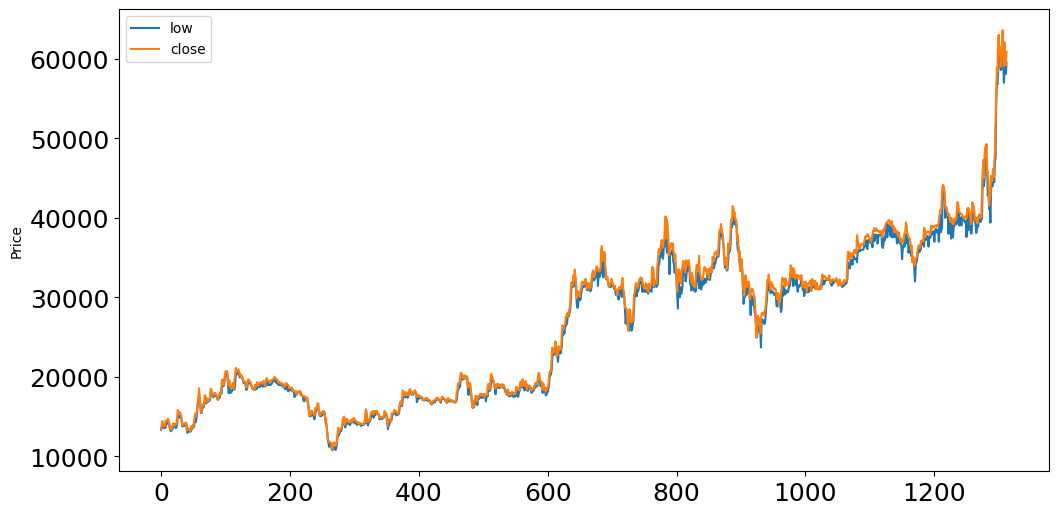

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.955
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.969
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


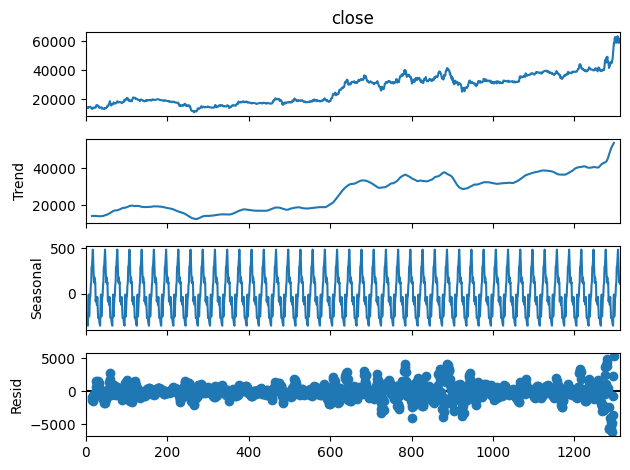

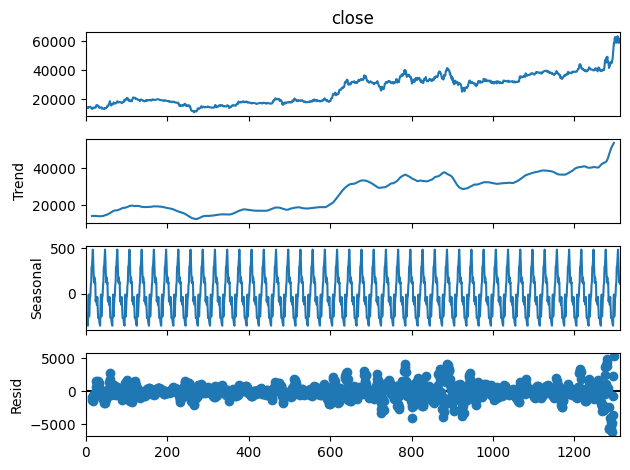

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-13.780354909057513,
 9.32133426352256e-26,
 3,
 782,
 {'1%': -3.4387398917732193,
  '5%': -2.8652430432199654,
  '10%': -2.5687418568690683},
 11692.529319168942)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

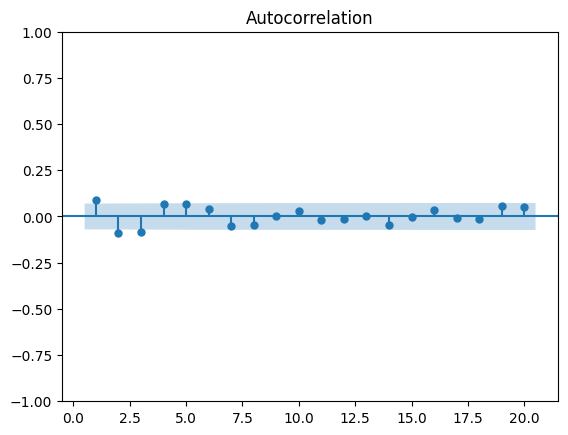

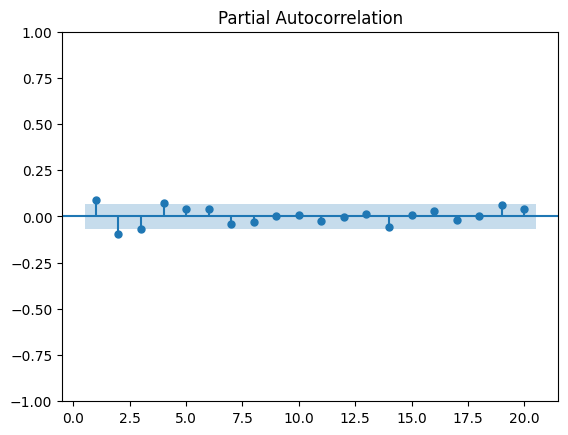

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=12022.896, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=12033.383, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=12027.496, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=12026.766, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=12034.629, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=12020.886, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=12019.158, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=12021.057, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=12027.139, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=12025.026, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[5] intercept   : AIC=12020.197, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[5] intercept   : AIC=12020.032, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=12028.518, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[5] intercept   : AIC=12023.044, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[5] intercept   : AIC=12022.041, Time=0.09

In [56]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  787
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6003.579
Date:                Mon, 03 Jun 2024   AIC                          12019.158
Time:                        21:40:43   BIC                          12047.160
Sample:                             0   HQIC                         12029.924
                                - 787                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     32.6274     22.858      1.427      0.153     -12.173      77.428
ar.L1          0.4391      0.103      4.252      0.000       0.237       0.642
ar.L2         -0.6803      0.089     -7.679      0.0

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([37825.0009076 , 36800.27614017, 34691.74144375, 36925.35687491,
       37129.26084888, 37125.15219833, 37496.59551077, 37395.03355291,
       36123.55414085, 35910.03693015, 34851.90757498, 35807.91632321,
       35278.86520642, 33691.70490626, 32113.8254411 , 30684.45229876,
       34219.83012258, 33116.24277697, 32011.72725934, 33171.93263858,
       32382.99297979, 32587.18912654, 33116.24277975, 35121.07767592,
       35807.91926071, 35176.76753414, 34759.09359744, 33848.56441544,
       34276.44815948, 35278.86560756, 35065.38781769, 35650.13132907,
       35965.70719235, 35223.17574933, 33589.60657469, 33431.81864305,
       32800.66691648, 33691.7046481 , 33645.29643292, 33274.03071141,
       32800.66691648, 33060.55292154, 32642.87898484, 32800.66691648,
       34489.92594935, 33960.8722962 , 34851.91002782, 33848.56441544,
       33060.55292154, 34592.02402276, 33274.03071141, 32902.7649899 ,
       33171.93263799, 33905.18243797, 33487.50850127, 33487.50850127,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([33611.13496847, 33588.82764911, 33373.7481324 , 33788.16152815,
       33667.20799581, 33551.7196288 , 33449.79914632, 33450.33526187,
       33190.55494093, 33339.02180869, 33338.99975982, 33376.12584732,
       33589.60617355, 33775.2396936 , 33552.48011194, 33775.23943033,
       34062.97035525, 36058.52361994, 35807.91926177, 35807.9192613 ,
       35371.68203795, 36281.28305556, 36392.66277207, 36095.65019488,
       35807.91926071, 36392.66277209, 36828.89999486, 36531.88741765,
       36457.63427335, 36457.63427335, 36531.88741765, 36095.65019488,
       37265.13721763, 37265.13721763, 37552.8681518 , 37552.8681518 ,
       37404.3618632 , 37552.8681518 , 37552.8681518 , 37552.8681518 ,
       37552.8681518 , 37552.8681518 , 37989.10537458, 37914.85223027,
       38026.23194673, 38638.82038722, 38638.82038722, 37627.1212961 ,
       38499.59574165, 38713.07353152, 38425.34259735, 38527.44067077,
       38564.56724292, 38276.83630875, 38425.34259735, 37840.59908597,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("The closing prices for the next 30 days:")
print(y_30_days_pred)

The closing prices for the next 30 days:
[39669.9433181  39777.72443367 39906.21114175 39940.22260536
 39949.35750794 39963.95757585 39982.84388526 40002.08871929
 40020.90312187 40039.57241951 40058.25908911 40076.96732293
 40095.67857777 40114.38795554 40133.09652526 40151.80512921
 40170.51383843 40189.22256848 40207.93129081 40226.6400088
 40245.3487267  40264.05744509 40282.76616362 40301.47488211
 40320.18360059 40338.89231906 40357.60103753 40376.309756
 40395.01847447 40413.72719295]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

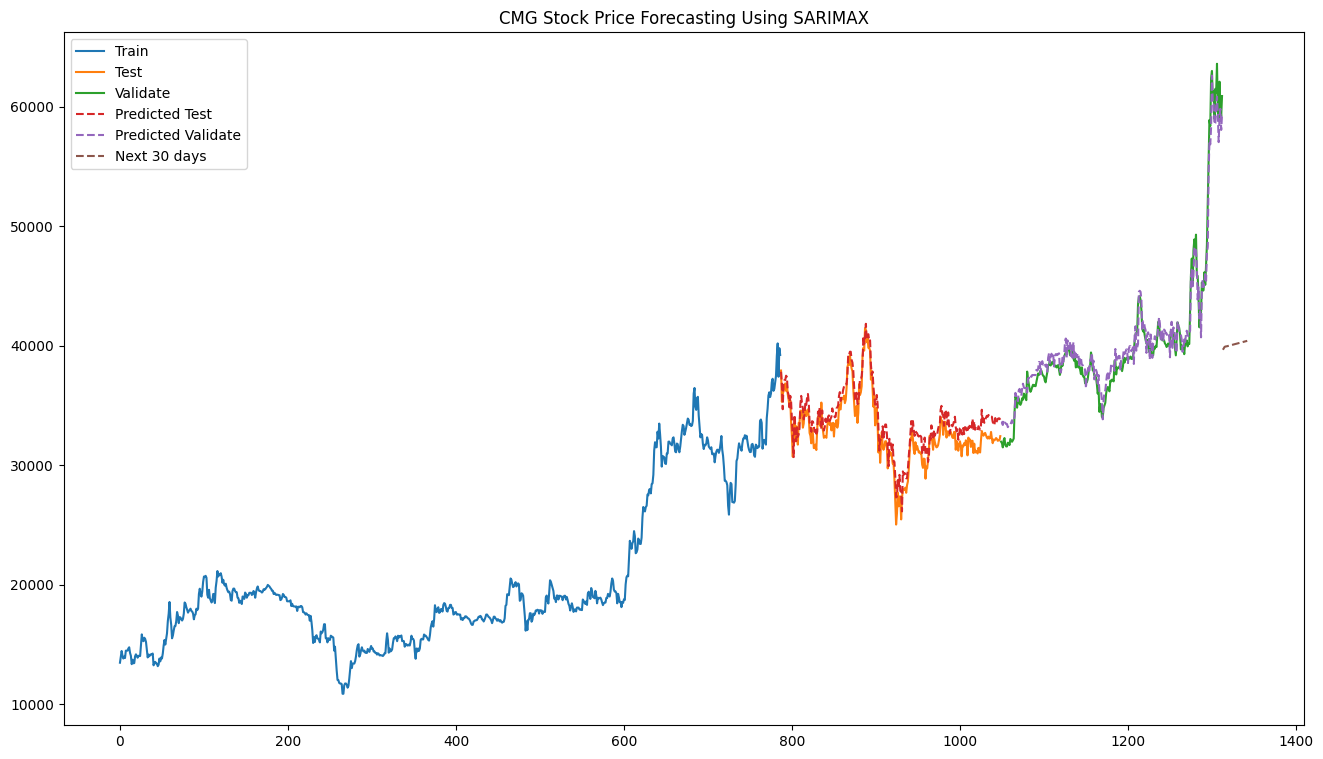

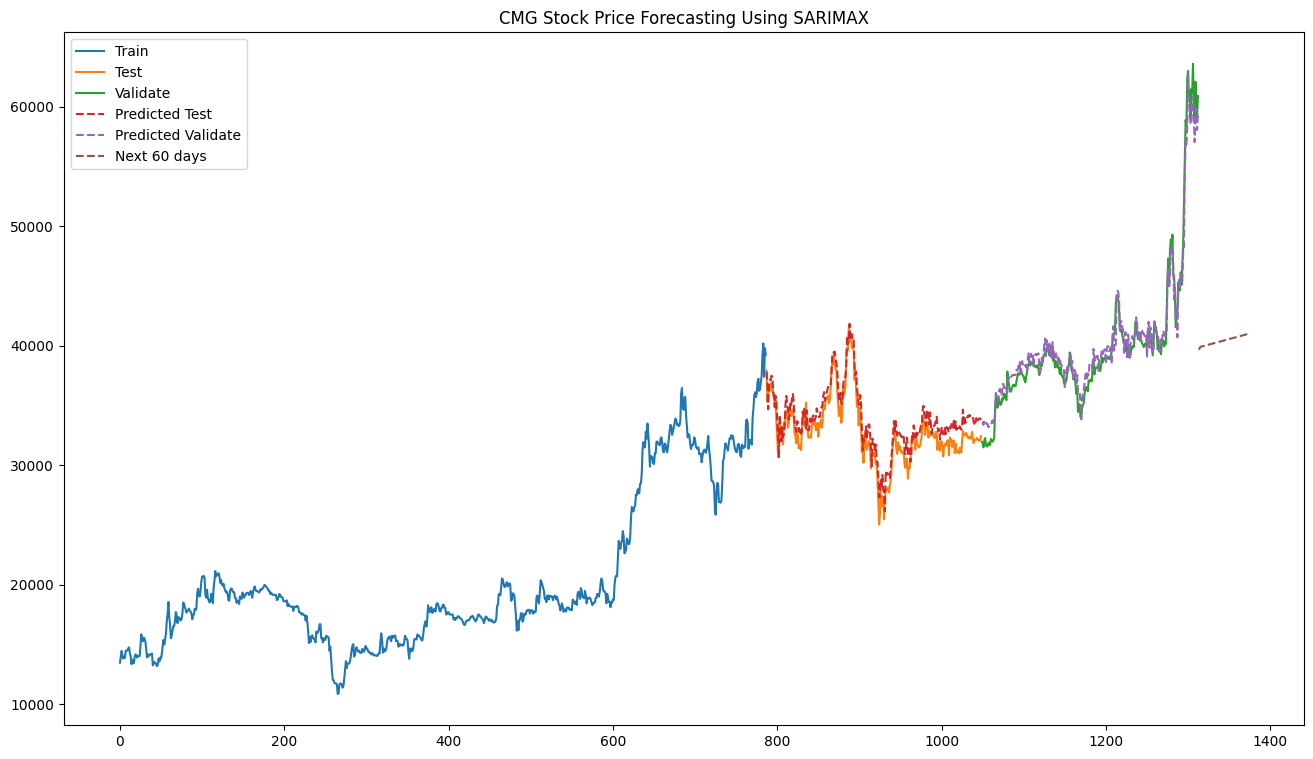

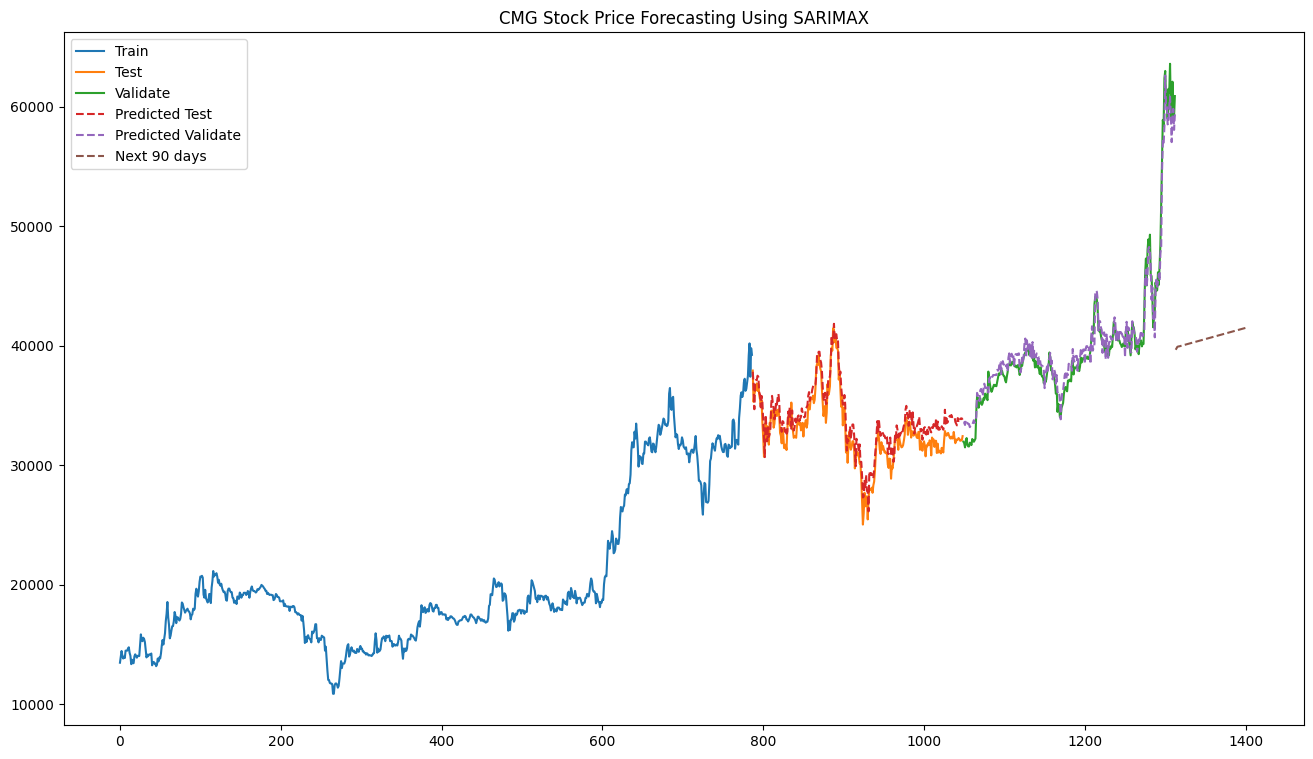

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 1217.6399302740006
MAE on test data: 1097.8776974426125
MAPE on test data: 3.4141613385576406 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1068.833559988701
MAE on validation data: 898.9776514709049
MAPE on validation data: 2.265325795746579 %
